# Research Question: Does follower size predict engagement rate differently across categories?

This notebook analyzes how follower count relates to engagement rate for different influencer categories.


In [40]:
# Ensure all necessary libraries are installed
!pip install --quiet pandas matplotlib seaborn scipy openpyxl



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [41]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import json
import os
from pathlib import Path


## Step 1: Load the datasets


In [42]:
# Load influencers dataset
influencers_path = "datasets/influencers.txt"
df_influencers = pd.read_csv(influencers_path, sep='\t')

# Remove separator lines (rows with "=" characters)
df_influencers = df_influencers[~df_influencers['Username'].str.contains('=', na=False)]

print(f"Influencers dataset: {len(df_influencers)} rows")
print(f"Columns: {df_influencers.columns.tolist()}")
df_influencers.head()


Influencers dataset: 33935 rows
Columns: ['Username', 'Category', '#Followers', '#Followees', '#Posts']


,Username,Category,#Followers,#Followees,#Posts
1,makeupbynvs,beauty,1432.0,1089.0,363.0
2,jaquelinevandoski,beauty,137600.0,548.0,569.0
3,anisaartistry,beauty,64644.0,289.0,391.0
4,rubina_muartistry,beauty,496406.0,742.0,887.0
5,beautyxabbi,beauty,2050.0,1423.0,751.0


In [43]:
## Step 1.5: Clean and Normalize Categories

# First, let's see all unique categories to identify issues
print("="*70)
print("CATEGORY ANALYSIS: Identifying malformed categories")
print("="*70)
print(f"\nTotal unique categories: {df_influencers['Category'].nunique()}")
print(f"\nAll unique categories:")
all_categories = df_influencers['Category'].value_counts().sort_index()
for cat, count in all_categories.items():
    print(f"  '{cat}': {count:,} influencers")

# Identify potential issues
print("\n" + "="*70)
print("POTENTIAL CATEGORY ISSUES:")
print("="*70)

# Common issues to look for:
# 1. Typos (fasion -> fashion)
# 2. Extra spaces or numbers (fashion 0.5 -> fashion)
# 3. Case inconsistencies (Fashion vs fashion)
# 4. Similar categories that might be duplicates

potential_issues = []
for cat in df_influencers['Category'].unique():
    cat_lower = str(cat).lower().strip()
    # Check for common typos
    if 'fasion' in cat_lower or 'fasio' in cat_lower:
        potential_issues.append((cat, 'fashion'))
    # Check for numbers/spaces in category names
    elif any(char.isdigit() for char in str(cat)) or '  ' in str(cat):
        potential_issues.append((cat, None))  # Need manual review
    # Check for trailing/leading spaces
    elif str(cat) != str(cat).strip():
        potential_issues.append((cat, str(cat).strip()))

if potential_issues:
    print("\nFound potential issues:")
    for old, new in potential_issues:
        if new:
            print(f"  '{old}' -> '{new}'")
        else:
            print(f"  '{old}' -> NEEDS MANUAL REVIEW")
else:
    print("\nNo obvious issues found automatically.")

# Create category mapping to fix known issues
category_mapping = {
    # Fix typos
    'fasion': 'fashion',
    'fasio': 'fashion',
    
    # Fix categories with numbers/spaces (common patterns)
    'fashion 0.5': 'fashion',
    'fashion 0': 'fashion',
    'fashion 1': 'fashion',
    'fashion 2': 'fashion',
    
    # Fix trailing/leading spaces (will handle programmatically)
}

# Also handle case normalization and whitespace
print("\n" + "="*70)
print("APPLYING CATEGORY FIXES:")
print("="*70)

# Store original counts
original_counts = df_influencers['Category'].value_counts()

# Step 1: Apply explicit mappings
df_influencers['Category'] = df_influencers['Category'].map(category_mapping).fillna(df_influencers['Category'])

# Step 2: Strip whitespace
df_influencers['Category'] = df_influencers['Category'].str.strip()

# Step 3: Normalize case (make lowercase for consistency)
# But first, let's see if case matters - maybe keep original case?
# Actually, let's keep original case but fix obvious issues

# Step 4: Find remaining potential duplicates (case-insensitive)
print("\nChecking for case-insensitive duplicates:")
category_lower_map = {}
for cat in df_influencers['Category'].unique():
    cat_lower = str(cat).lower()
    if cat_lower not in category_lower_map:
        category_lower_map[cat_lower] = []
    category_lower_map[cat_lower].append(cat)

duplicates_found = {k: v for k, v in category_lower_map.items() if len(v) > 1}
if duplicates_found:
    print("\nFound case-insensitive duplicates (may need manual review):")
    for lower, variants in duplicates_found.items():
        print(f"  '{lower}': {variants}")
        # Use the most common variant
        variant_counts = {v: (df_influencers['Category'] == v).sum() for v in variants}
        most_common = max(variant_counts, key=variant_counts.get)
        print(f"    -> Standardizing to: '{most_common}'")
        for variant in variants:
            if variant != most_common:
                df_influencers.loc[df_influencers['Category'] == variant, 'Category'] = most_common
else:
    print("  No case-insensitive duplicates found.")

# Show before/after comparison
print("\n" + "="*70)
print("BEFORE vs AFTER COMPARISON:")
print("="*70)
print(f"\nCategories before: {original_counts.shape[0]}")
print(f"Categories after: {df_influencers['Category'].nunique()}")

print("\nUpdated category counts:")
updated_counts = df_influencers['Category'].value_counts().sort_index()
for cat, count in updated_counts.items():
    print(f"  '{cat}': {count:,} influencers")

print("\n" + "="*70)
print("✓ Category cleaning complete!")
print("="*70)


CATEGORY ANALYSIS: Identifying malformed categories

Total unique categories: 11

All unique categories:
  'beauty': 1,542 influencers
  'family': 4,070 influencers
  'fashion': 11,911 influencers
  'fashion 0.5': 1 influencers
  'fasion': 1 influencers
  'fitness': 1,133 influencers
  'food': 3,565 influencers
  'interior': 1,195 influencers
  'other': 5,720 influencers
  'pet': 587 influencers
  'travel': 4,210 influencers

POTENTIAL CATEGORY ISSUES:

Found potential issues:
  'fasion' -> 'fashion'
  'fashion 0.5' -> NEEDS MANUAL REVIEW

APPLYING CATEGORY FIXES:

Checking for case-insensitive duplicates:
  No case-insensitive duplicates found.

BEFORE vs AFTER COMPARISON:

Categories before: 11
Categories after: 9

Updated category counts:
  'beauty': 1,542 influencers
  'family': 4,070 influencers
  'fashion': 11,913 influencers
  'fitness': 1,133 influencers
  'food': 3,565 influencers
  'interior': 1,195 influencers
  'other': 5,720 influencers
  'pet': 587 influencers
  'travel':

In [44]:
# Create mapping from JSON files to influencers
# Extract usernames from JSON filenames (format: username-postid.info)
import glob

info_folder = "datasets/posts_info/info"
post_mapping = []

print("Creating post-to-influencer mapping from JSON filenames...")
print(f"Looking in folder: {info_folder}")
print("(This may take a moment...)")

try:
    # Get all .info files from the unzipped folder
    json_files = glob.glob(os.path.join(info_folder, "*.info"))
    print(f"Found {len(json_files)} JSON files")
    
    # Extract username from each filename
    # Format: username-postid.info
    # Process all files (we were supposed to have 300 posts per influencer, but only extracted a fraction)
    for json_file_path in json_files:
        # Get just the filename (without path)
        filename = os.path.basename(json_file_path)
        # Remove '.info' suffix
        filename_no_ext = filename.replace('.info', '')
        # Split by '-' - username is everything before the last part (post ID)
        parts = filename_no_ext.split('-')
        if len(parts) >= 2:
            # Username might be multiple parts joined by '-', post ID is the last part
            # Try to extract username (everything except the last numeric part)
            username = '-'.join(parts[:-1])  # Everything except last part
            post_id = parts[-1]
            post_mapping.append({
                'influencer_name': username,
                'JSON_PostMetadata_file_name': filename
            })
    
    df_mapping = pd.DataFrame(post_mapping)
    print(f"Created mapping for {len(df_mapping)} posts")
    print(f"Sample mapping:")
    print(df_mapping.head())
    
except Exception as e:
    print(f"Error accessing files: {e}")
    print(f"Make sure you've unzipped posts_info.zip to {info_folder}")
    df_mapping = pd.DataFrame(columns=['influencer_name', 'JSON_PostMetadata_file_name'])


Creating post-to-influencer mapping from JSON filenames...
Looking in folder: datasets/posts_info/info
(This may take a moment...)
Found 39907 JSON files
Created mapping for 39907 posts
Sample mapping:
  influencer_name             JSON_PostMetadata_file_name
0     lelien_tomo    lelien_tomo-1830138903170861888.info
1    veverkakokos   veverkakokos-1489332816747241995.info
2      alicekings     alicekings-1969215886536407515.info
3   nicolenic1973  nicolenic1973-1910237140220224662.info
4         aleyahs        aleyahs-1838455027463857801.info


## Step 2: Merge datasets


In [45]:
print(f"Number of rows in influencer dataset before merge: {len(df_influencers)}")
# Merge influencers with post mapping
# LEFT MERGE: Keep all influencers, add their post data
# This creates multiple rows per influencer (one for each post)
if len(df_mapping) > 0:
    df = pd.merge(df_influencers, df_mapping, 
                   left_on='Username', 
                   right_on='influencer_name', 
                   how='left')
    
    print(f"After merge: {len(df)} rows")
    print(f"  (Each influencer now has multiple rows - one per post)")
    print(f"  Posts matched: {df['JSON_PostMetadata_file_name'].notna().sum()}")
    df.head()
else:
    print("No mapping data available. Using influencers dataset only.")
    df = df_influencers.copy()


Number of rows in influencer dataset before merge: 33935
After merge: 50736 rows
  (Each influencer now has multiple rows - one per post)
  Posts matched: 39907


## Step 3: Load engagement data from JSON files

The JSON files have been unzipped and are in the `datasets/posts_info/info/` folder.
We'll load them directly using the structure documented in INFO_FILE_STRUCTURE.md.


### Debug: Check JSON file structure

Let's first check what keys are actually in the JSON files to find likes, comments, shares.


In [46]:
# Debug: Check structure of first JSON file
import json
import os

info_folder = "datasets/posts_info/info"
df_with_files = df[df['JSON_PostMetadata_file_name'].notna()].copy()
first_file = df_with_files['JSON_PostMetadata_file_name'].iloc[0]

print(f"Checking file: {first_file}")

json_file_path = os.path.join(info_folder, first_file)

try:
    if os.path.exists(json_file_path):
        with open(json_file_path, 'r') as f:
            sample_data = json.load(f)
        
        print(f"\nAll keys in JSON file:")
        print(list(sample_data.keys())[:30])
        
        print(f"\nLooking for likes/comments/shares...")
        # Search for any key containing 'like', 'comment', 'share'
        like_keys = [k for k in sample_data.keys() if 'like' in k.lower()]
        comment_keys = [k for k in sample_data.keys() if 'comment' in k.lower()]
        share_keys = [k for k in sample_data.keys() if 'share' in k.lower()]
        
        print(f"\nKeys with 'like': {like_keys}")
        print(f"Keys with 'comment': {comment_keys}")
        print(f"Keys with 'share': {share_keys}")
        
        # Check if keys were found and print confirmation
        print(f"\n{'='*60}")
        print("KEY DETECTION RESULTS:")
        print(f"{'='*60}")
        
        # Check for likes
        if like_keys:
            print(f" FOUND likes keys: {like_keys}")
            for key in like_keys:
                val = sample_data[key]
                if isinstance(val, dict):
                    if 'count' in val:
                        print(f"  -> {key}['count'] = {val['count']}")
                    else:
                        print(f"  -> {key} is a dict with keys: {list(val.keys())[:5]}")
                else:
                    print(f"  -> {key} = {val}")
        else:
            print(f" NO likes keys found")
        
        # Check for comments
        if comment_keys:
            print(f"\n FOUND comments keys: {comment_keys}")
            for key in comment_keys:
                val = sample_data[key]
                if isinstance(val, dict):
                    if 'count' in val:
                        print(f"  -> {key}['count'] = {val['count']}")
                    else:
                        print(f"  -> {key} is a dict with keys: {list(val.keys())[:5]}")
                else:
                    print(f"  -> {key} = {val}")
        else:
            print(f"\n NO comments keys found")
        
        # Check for shares
        if share_keys:
            print(f"\n FOUND shares keys: {share_keys}")
            for key in share_keys:
                val = sample_data[key]
                if isinstance(val, dict):
                    if 'count' in val:
                        print(f"  -> {key}['count'] = {val['count']}")
                    else:
                        print(f"  -> {key} is a dict with keys: {list(val.keys())[:5]}")
                else:
                    print(f"  -> {key} = {val}")
        else:
            print(f"\n NO shares keys found")
        
        print(f"\n{'='*60}")
        
        # Show structure of first few keys
        print(f"\nSample values (first 10 keys):")
        for key in list(sample_data.keys())[:10]:
            val = sample_data[key]
            if isinstance(val, dict):
                print(f"  {key}: dict with keys {list(val.keys())[:5]}")
                # If it's a dict, check if it has 'count'
                if 'count' in val:
                    print(f"    -> count: {val['count']}")
            elif isinstance(val, (int, float)):
                print(f"  {key}: {val}")
            else:
                print(f"  {key}: {type(val).__name__}")
    else:
        print(f"File not found: {json_file_path}")
        print(f"Make sure you've unzipped posts_info.zip to datasets/posts_info/")
except Exception as e:
    print(f"Error: {e}")
    import traceback
    traceback.print_exc()


Checking file: makeupbynvs-1947413530999751148.info

All keys in JSON file:
['gating_info', 'viewer_can_reshare', 'display_resources', 'viewer_in_photo_of_you', 'viewer_has_saved_to_collection', 'viewer_has_saved', 'owner', 'viewer_has_liked', 'id', 'should_log_client_event', 'edge_media_preview_like', 'edge_media_to_tagged_user', 'dimensions', '__typename', 'location', 'shortcode', 'is_ad', 'caption_is_edited', 'edge_media_to_parent_comment', 'media_preview', 'taken_at_timestamp', 'edge_media_to_caption', 'tracking_token', 'has_ranked_comments', 'display_url', 'edge_web_media_to_related_media', 'edge_media_preview_comment', 'comments_disabled', 'edge_media_to_sponsor_user', 'accessibility_caption']

Looking for likes/comments/shares...

Keys with 'like': ['viewer_has_liked', 'edge_media_preview_like']
Keys with 'comment': ['edge_media_to_parent_comment', 'has_ranked_comments', 'edge_media_preview_comment', 'comments_disabled']
Keys with 'share': ['viewer_can_reshare']

KEY DETECTION R

In [47]:
# Function to load engagement data from a JSON file
# Based on actual JSON structure found in debug output
def load_post_engagement(json_file_path):
    """Load engagement metrics from a JSON file
    
    Actual structure found in JSON files:
    - Likes: edge_media_preview_like.count
    - Comments: edge_media_preview_comment.count (or edge_media_to_parent_comment.count)
    - Shares: Not directly available (set to 0)
    """
    try:
        with open(json_file_path, 'r') as f:
            data = json.load(f)
        
        # Extract likes from edge_media_preview_like.count
        likes = None
        if 'edge_media_preview_like' in data:
            if isinstance(data['edge_media_preview_like'], dict) and 'count' in data['edge_media_preview_like']:
                likes = data['edge_media_preview_like']['count']
        
        # Extract comments - try multiple possible keys
        # Based on debug output, actual keys are:
        # - edge_media_preview_comment.count
        # - edge_media_to_parent_comment.count
        comments = None
        if 'edge_media_preview_comment' in data:
            if isinstance(data['edge_media_preview_comment'], dict) and 'count' in data['edge_media_preview_comment']:
                comments = data['edge_media_preview_comment']['count']
        elif 'edge_media_to_parent_comment' in data:
            if isinstance(data['edge_media_to_parent_comment'], dict) and 'count' in data['edge_media_to_parent_comment']:
                comments = data['edge_media_to_parent_comment']['count']
        
        # Shares not available in this structure (set to 0)
        shares = 0
        
        result = {
            'likes': likes,
            'comments': comments,
            'shares': shares,
            'engagement_rate': None  # Will calculate later
        }
        return result
    except Exception as e:
        return {'likes': None, 'comments': None, 'shares': None, 'engagement_rate': None}

print("Function created! Fixed to use correct comment keys: edge_media_preview_comment or edge_media_to_parent_comment")


Function created! Fixed to use correct comment keys: edge_media_preview_comment or edge_media_to_parent_comment


In [48]:
# Get unique JSON file names for loading engagement data
df_with_files = df[df['JSON_PostMetadata_file_name'].notna()].copy()
unique_files = df_with_files['JSON_PostMetadata_file_name'].unique()

print(f"Found {len(unique_files)} unique JSON metadata files to load")
print(f"Loading engagement data from {len(unique_files)} files...")
print("(This may take a few minutes...)")


Found 39907 unique JSON metadata files to load
Loading engagement data from 39907 files...
(This may take a few minutes...)


In [49]:
# Load engagement data from JSON files
# Files are in datasets/posts_info/info/ folder
info_folder = "datasets/posts_info/info"
engagement_data = {}
files_to_load = unique_files  # Load all available files

print(f"Loading engagement data from {len(files_to_load)} JSON files...")
print(f"Looking in folder: {info_folder}")
print("(This may take a few minutes...)")

files_loaded = 0
files_not_found = 0

for i, json_file in enumerate(files_to_load):
    if i % 1000 == 0:
        print(f"  Loading file {i+1}/{len(files_to_load)}...")
    
    # Construct full path to JSON file
    json_file_path = os.path.join(info_folder, json_file)
    
    if os.path.exists(json_file_path):
        engagement_data[json_file] = load_post_engagement(json_file_path)
        files_loaded += 1
    else:
        files_not_found += 1
        engagement_data[json_file] = {'likes': None, 'comments': None, 'shares': None, 'engagement_rate': None}

print(f"\n Loaded {files_loaded} files")
print(f"  Files not found: {files_not_found}")

# Check how many files actually have data
files_with_likes = sum(1 for v in engagement_data.values() if v.get('likes') is not None)
files_with_comments = sum(1 for v in engagement_data.values() if v.get('comments') is not None)
print(f"\nFiles with likes data: {files_with_likes}")
print(f"Files with comments data: {files_with_comments}")


Loading engagement data from 39907 JSON files...
Looking in folder: datasets/posts_info/info
(This may take a few minutes...)
  Loading file 1/39907...
  Loading file 1001/39907...
  Loading file 2001/39907...
  Loading file 3001/39907...
  Loading file 4001/39907...
  Loading file 5001/39907...
  Loading file 6001/39907...
  Loading file 7001/39907...
  Loading file 8001/39907...
  Loading file 9001/39907...
  Loading file 10001/39907...
  Loading file 11001/39907...
  Loading file 12001/39907...
  Loading file 13001/39907...
  Loading file 14001/39907...
  Loading file 15001/39907...
  Loading file 16001/39907...
  Loading file 17001/39907...
  Loading file 18001/39907...
  Loading file 19001/39907...
  Loading file 20001/39907...
  Loading file 21001/39907...
  Loading file 22001/39907...
  Loading file 23001/39907...
  Loading file 24001/39907...
  Loading file 25001/39907...
  Loading file 26001/39907...
  Loading file 27001/39907...
  Loading file 28001/39907...
  Loading file 29

In [50]:
# Add engagement data to dataframe
# Calculate total likes, comments, and shares for each post (each row is a post)
df['Likes'] = df['JSON_PostMetadata_file_name'].map(lambda x: engagement_data.get(x, {}).get('likes'))
df['Comments'] = df['JSON_PostMetadata_file_name'].map(lambda x: engagement_data.get(x, {}).get('comments'))
df['Shares'] = df['JSON_PostMetadata_file_name'].map(lambda x: engagement_data.get(x, {}).get('shares'))

# Fill missing values with 0 (posts with no engagement data)
df['Likes'] = df['Likes'].fillna(0)
df['Comments'] = df['Comments'].fillna(0)
df['Shares'] = df['Shares'].fillna(0)

# Calculate total engagement per post
df['Total_Engagement'] = df['Likes'] + df['Comments'] + df['Shares']

# Calculate engagement rate: (Total Engagement / Followers) * 100
# Handle division by zero - set to 0 if followers is 0
df['Engagement_Rate'] = (df['Total_Engagement'] / df['#Followers']) * 100
df['Engagement_Rate'] = df['Engagement_Rate'].fillna(0)  # Fill any NaN values with 0

print(f"Posts with likes data: {df['Likes'].notna().sum()}")
print(f"Posts with comments data: {df['Comments'].notna().sum()}")
print(f"Posts with shares data: {df['Shares'].notna().sum()}")
print(f"\nSample data:")
print(df[['Username', '#Followers', 'Likes', 'Comments', 'Shares', 'Total_Engagement', 'Engagement_Rate']].head(10))


Posts with likes data: 50736
Posts with comments data: 50736
Posts with shares data: 50736

Sample data:
            Username  #Followers    Likes  Comments  Shares  Total_Engagement  \
0        makeupbynvs      1432.0     70.0       6.0     0.0              76.0   
1  jaquelinevandoski    137600.0  19770.0      98.0     0.0           19868.0   
2  jaquelinevandoski    137600.0   9261.0      44.0     0.0            9305.0   
3      anisaartistry     64644.0   3125.0      33.0     0.0            3158.0   
4  rubina_muartistry    496406.0  11053.0      81.0     0.0           11134.0   
5  rubina_muartistry    496406.0   4293.0      71.0     0.0            4364.0   
6        beautyxabbi      2050.0      0.0       0.0     0.0               0.0   
7        vemakeup713     99226.0      0.0       0.0     0.0               0.0   
8       glaminfusion      4717.0    213.0      81.0     0.0             294.0   
9       glaminfusion      4717.0    728.0      91.0     0.0             819.0   

   

In [51]:
## Step 4: Create Cleaned Influencer-Level Dataset

# Aggregate from post-level to influencer-level
# Group by Username (primary identifier) and aggregate engagement metrics
# NOTE: We don't include #Posts since we only have data from 300 random posts mapped from JSON
df_cleaned = df.groupby('Username').agg({
    'Category': 'first',                    # Same for all rows of same influencer
    '#Followers': 'first',                  # Same for all rows
    'Likes': 'sum',                         # Total likes across all posts
    'Comments': 'sum',                      # Total comments across all posts
    'Total_Engagement': 'sum'               # Total engagement across all posts
}).reset_index()

# Calculate average likes and comments per post
# Count number of posts per influencer (posts with engagement data)
post_counts = df.groupby('Username').size().reset_index(name='Posts_With_Data')
df_cleaned = df_cleaned.merge(post_counts, on='Username', how='left')

# Calculate averages (handle division by zero)
df_cleaned['Avg_Likes'] = df_cleaned['Likes'] / df_cleaned['Posts_With_Data']
df_cleaned['Avg_Comments'] = df_cleaned['Comments'] / df_cleaned['Posts_With_Data']
df_cleaned['Avg_Likes'] = df_cleaned['Avg_Likes'].fillna(0)
df_cleaned['Avg_Comments'] = df_cleaned['Avg_Comments'].fillna(0)

# Calculate engagement rate: (Total Engagement / Followers) * 100
df_cleaned['Engagement_Rate'] = (df_cleaned['Total_Engagement'] / df_cleaned['#Followers']) * 100
df_cleaned['Engagement_Rate'] = df_cleaned['Engagement_Rate'].fillna(0)  # Handle division by zero

# Handle influencers with no posts (missing engagement data)
# Start with all influencers from original dataset
# NOTE: Don't include #Posts here - we'll use Posts_With_Data instead
all_influencers = df_influencers[['Username', 'Category', '#Followers']].copy()

# Check for any missing values in base columns
if all_influencers.isnull().sum().sum() > 0:
    print("⚠ WARNING: Found missing values in base influencer data:")
    print(all_influencers.isnull().sum())
    # Fill any missing values (though there shouldn't be any)
    all_influencers['Category'] = all_influencers['Category'].fillna('Unknown')
    all_influencers['#Followers'] = all_influencers['#Followers'].fillna(0)

# Merge with aggregated engagement data (left join to keep all influencers)
df_cleaned = all_influencers.merge(
    df_cleaned[['Username', 'Likes', 'Comments', 'Total_Engagement', 'Avg_Likes', 'Avg_Comments', 'Engagement_Rate', 'Posts_With_Data']],
    on='Username',
    how='left'
)

# Set #Posts to the actual number of posts we have data for (not total Instagram posts)
# We were supposed to have 300 posts per influencer, but only extracted a fraction
df_cleaned['#Posts'] = df_cleaned['Posts_With_Data'].fillna(0)

# Fill missing engagement values with 0 for influencers with no posts
df_cleaned['Likes'] = df_cleaned['Likes'].fillna(0)
df_cleaned['Comments'] = df_cleaned['Comments'].fillna(0)
df_cleaned['Total_Engagement'] = df_cleaned['Total_Engagement'].fillna(0)
df_cleaned['Avg_Likes'] = df_cleaned['Avg_Likes'].fillna(0)
df_cleaned['Avg_Comments'] = df_cleaned['Avg_Comments'].fillna(0)
df_cleaned['Engagement_Rate'] = df_cleaned['Engagement_Rate'].fillna(0)

# Select only the requested columns in the specified order
# NOTE: #Posts is the number of posts we have data for (not total Instagram posts)
# We were supposed to have 300 posts per influencer, but only extracted a fraction
df_final = df_cleaned[[
    'Username',           # influencer_name (using Username as primary identifier)
    'Category',
    '#Followers',
    '#Posts',             # Number of posts we have engagement data for (not total Instagram posts)
    'Likes',              # Total likes
    'Comments',           # Total comments
    'Total_Engagement',   # Total engagements
    'Engagement_Rate',    # Calculated engagement rate
    'Avg_Likes',          # Average likes per post
    'Avg_Comments'        # Average comments per post
]].copy()

# Rename Username to influencer_name for clarity
df_final = df_final.rename(columns={'Username': 'influencer_name'})

# Verify all columns are filled (no missing values)
print("="*70)
print("CLEANED INFLUENCER-LEVEL DATASET CREATED")
print("="*70)
print(f"\nTotal influencers: {len(df_final):,}")
print(f"Influencers with engagement data: {(df_final['Total_Engagement'] > 0).sum():,}")
print(f"Influencers with no posts (0 engagement): {(df_final['Total_Engagement'] == 0).sum():,}")

print(f"\n{'='*70}")
print("DATA COMPLETENESS CHECK:")
print(f"{'='*70}")
missing_counts = df_final.isnull().sum()
if missing_counts.sum() == 0:
    print("✓ ALL COLUMNS ARE COMPLETE - No missing values!")
    print(f"\nAll {len(df_final)} rows have all {len(df_final.columns)} columns filled.")
else:
    print("⚠ WARNING: Some missing values found:")
    print(missing_counts[missing_counts > 0])

print(f"\nColumn data types and non-null counts:")
print(df_final.info())

print(f"\nColumns: {list(df_final.columns)}")
print(f"\nSample data (first 10 rows):")
print(df_final.head(10))
print(f"\nDataset shape: {df_final.shape}")
print("="*70)


CLEANED INFLUENCER-LEVEL DATASET CREATED

Total influencers: 33,935
Influencers with engagement data: 23,103
Influencers with no posts (0 engagement): 10,832

DATA COMPLETENESS CHECK:
✓ ALL COLUMNS ARE COMPLETE - No missing values!

All 33935 rows have all 10 columns filled.

Column data types and non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33935 entries, 0 to 33934
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   influencer_name   33935 non-null  object 
 1   Category          33935 non-null  object 
 2   #Followers        33935 non-null  float64
 3   #Posts            33935 non-null  int64  
 4   Likes             33935 non-null  float64
 5   Comments          33935 non-null  float64
 6   Total_Engagement  33935 non-null  float64
 7   Engagement_Rate   33935 non-null  float64
 8   Avg_Likes         33935 non-null  float64
 9   Avg_Comments      33935 non-null  float64
dtypes: flo

In [52]:
## Data Quality Check: Analyzing Zero Values and Potential Issues

print("="*70)
print("DATA QUALITY ANALYSIS: Zero Values and Logical Issues")
print("="*70)

# Check for different types of zero values
print("\n1. INFLUENCERS WITH ZERO FOLLOWERS:")
zero_followers = df_final[df_final['#Followers'] == 0]
print(f"   Count: {len(zero_followers)}")
if len(zero_followers) > 0:
    print("   ⚠️ ISSUE: Cannot calculate engagement rate with 0 followers")
    print("   Recommendation: Exclude these from analysis")
    print(zero_followers.head())

print("\n2. INFLUENCERS WITH ZERO POSTS:")
zero_posts = df_final[df_final['#Posts'] == 0]
print(f"   Count: {len(zero_posts)}")
if len(zero_posts) > 0:
    print("   Note: These influencers have no posts with engagement data in the dataset")
    print("   This is expected - we were supposed to have 300 posts per influencer but only extracted a fraction")

print("\n3. INFLUENCERS WITH ZERO ENGAGEMENT:")
zero_engagement = df_final[df_final['Total_Engagement'] == 0]
print(f"   Count: {len(zero_engagement):,} ({len(zero_engagement)/len(df_final)*100:.1f}%)")
print("   Breakdown:")
print(f"     - With posts but no engagement: {(zero_engagement['#Posts'] > 0).sum()}")
print(f"     - With no posts: {(zero_engagement['#Posts'] == 0).sum()}")
print("   Note: These influencers have no engagement data in JSON files")
print("   ⚠️ CONSIDERATION: Including these may affect correlation analysis")

print("\n4. INFLUENCERS WITH ZERO ENGAGEMENT RATE:")
zero_rate = df_final[df_final['Engagement_Rate'] == 0]
print(f"   Count: {len(zero_rate):,} ({len(zero_rate)/len(df_final)*100:.1f}%)")
print("   Reasons:")
print(f"     - Zero engagement: {(zero_rate['Total_Engagement'] == 0).sum()}")
print(f"     - Zero followers: {(zero_rate['#Followers'] == 0).sum()}")
print("   ⚠️ CONSIDERATION: Zero rates might skew correlation analysis")

print("\n5. RECOMMENDATIONS FOR YOUR RESEARCH QUESTION:")
print("   Research Question: Does follower size predict engagement rate differently across categories?")
print("\n   For correlation analysis, consider:")
print("   ✓ Option A: Include all influencers (conservative approach)")
print("     - Pros: Complete dataset, no data loss")
print("     - Cons: Zero values may weaken correlations")
print("\n   ✓ Option B: Filter to influencers with engagement data")
print("     - Filter: Total_Engagement > 0 AND #Followers > 0")
print("     - Pros: Focuses on active influencers, stronger correlations")
print("     - Cons: Excludes inactive influencers")
print("\n   ✓ Option C: Filter to influencers with minimum thresholds")
print("     - Filter: #Followers >= 1000 AND Total_Engagement > 0")
print("     - Pros: Removes edge cases, more realistic analysis")
print("     - Cons: Further reduces sample size")

print("\n" + "="*70)
print("SUMMARY STATISTICS:")
print("="*70)
print(f"Total influencers: {len(df_final):,}")
print(f"  - With engagement data: {(df_final['Total_Engagement'] > 0).sum():,}")
print(f"  - With zero engagement: {(df_final['Total_Engagement'] == 0).sum():,}")
print(f"  - With zero followers: {(df_final['#Followers'] == 0).sum():,}")
print(f"  - With zero posts: {(df_final['#Posts'] == 0).sum():,}")

# Create filtered dataset for analysis (recommended)
df_analysis = df_final[
    (df_final['#Followers'] > 0) &  # Must have followers
    (df_final['Total_Engagement'] > 0)  # Must have some engagement
].copy()

print(f"\nRecommended analysis dataset (with engagement & followers): {len(df_analysis):,} influencers")
print(f"  ({len(df_analysis)/len(df_final)*100:.1f}% of total dataset)")
print("="*70)


DATA QUALITY ANALYSIS: Zero Values and Logical Issues

1. INFLUENCERS WITH ZERO FOLLOWERS:
   Count: 0

2. INFLUENCERS WITH ZERO POSTS:
   Count: 0

3. INFLUENCERS WITH ZERO ENGAGEMENT:
   Count: 10,832 (31.9%)
   Breakdown:
     - With posts but no engagement: 10832
     - With no posts: 0
   Note: These influencers have no engagement data in JSON files
   ⚠️ CONSIDERATION: Including these may affect correlation analysis

4. INFLUENCERS WITH ZERO ENGAGEMENT RATE:
   Count: 10,832 (31.9%)
   Reasons:
     - Zero engagement: 10832
     - Zero followers: 0
   ⚠️ CONSIDERATION: Zero rates might skew correlation analysis

5. RECOMMENDATIONS FOR YOUR RESEARCH QUESTION:
   Research Question: Does follower size predict engagement rate differently across categories?

   For correlation analysis, consider:
   ✓ Option A: Include all influencers (conservative approach)
     - Pros: Complete dataset, no data loss
     - Cons: Zero values may weaken correlations

   ✓ Option B: Filter to influence

In [53]:
## Save Cleaned Datasets to Files

# Using cleaned_dataset_filtered.csv (no zeros in any engagement metric)

# Use the filtered dataset (no zeros)
# Note: df_filtered is created in Cell 17, so make sure to run that cell first
if 'df_filtered' not in locals():
    print("⚠️ df_filtered not found. Loading from cleaned_dataset_filtered.csv...")
    df_filtered = pd.read_csv('datasets/cleaned_dataset_filtered.csv')
    print(f"✓ Loaded {len(df_filtered):,} influencers from cleaned_dataset_filtered.csv")


import os

# Create datasets directory if it doesn't exist
os.makedirs('datasets', exist_ok=True)

# FIX: Remove all rows with zeros in engagement metrics
# Filter out rows where any engagement metric is 0
df_filtered = df_analysis[
    (df_analysis['Likes'] > 0) &
    (df_analysis['Comments'] > 0) &
    (df_analysis['Total_Engagement'] > 0) &
    (df_analysis['Engagement_Rate'] > 0) &
    (df_analysis['Avg_Likes'] > 0) &
    (df_analysis['Avg_Comments'] > 0)
].copy()

print("="*70)
print("FILTERING DATASET: Removing rows with zeros")
print("="*70)
print(f"Before filtering: {len(df_analysis):,} rows")
print(f"After filtering (no zeros): {len(df_filtered):,} rows")
print(f"Rows removed: {len(df_analysis) - len(df_filtered):,}")

# Save the filtered dataset (no zeros)
filtered_file = 'datasets/cleaned_dataset_filtered.csv'
df_filtered.to_csv(filtered_file, index=False)
print(f"\n✓ Saved filtered dataset (no zeros) to: {filtered_file}")
print(f"  Rows: {len(df_filtered):,}")
print(f"  Columns: {len(df_filtered.columns)}")
print(f"  File size: {os.path.getsize(filtered_file) / 1024 / 1024:.2f} MB")

# Save the analysis-ready dataset (filtered)
analysis_file = 'datasets/cleaned_dataset.csv'
df_analysis.to_csv(analysis_file, index=False)
print(f"\n✓ Saved analysis-ready dataset to: {analysis_file}")
print(f"  Rows: {len(df_analysis):,}")
print(f"  Columns: {len(df_analysis.columns)}")
print(f"  File size: {os.path.getsize(analysis_file) / 1024 / 1024:.2f} MB")

# Save the complete dataset (all influencers, including zeros)
complete_file = 'datasets/cleaned_dataset_complete.csv'
df_filtered.to_csv(complete_file, index=False)
print(f"\n✓ Saved complete dataset to: {complete_file}")
print(f"  Rows: {len(df_filtered):,}")
print(f"  Columns: {len(df_filtered.columns)}")
print(f"  File size: {os.path.getsize(complete_file) / 1024 / 1024:.2f} MB")

print("\n" + "="*70)
print("DATASET FILES CREATED FOR TEAM USE")
print("="*70)
print("\n Files saved in 'datasets/' folder:")
print(f"  1. cleaned_dataset_filtered.csv")
print(f"     → Filtered dataset (no zeros in any engagement metric)")
print(f"     → Use this for analysis requiring complete engagement data")
print(f"     → {len(df_filtered):,} influencers")
print(f"\n  2. cleaned_dataset.csv")
print(f"     → Analysis-ready dataset (filtered: followers > 0, engagement > 0)")
print(f"     → Use this for correlation analysis and statistical tests")
print(f"     → {len(df_analysis):,} influencers")
print(f"\n  3. cleaned_dataset_complete.csv")
print(f"     → Complete dataset (all influencers, includes zeros)")
print(f"     → Use this for exploratory analysis or if you need all data")
print(f"     → {len(df_filtered):,} influencers")
print("\n Column descriptions:")
print("   - influencer_name: Instagram username")
print("   - Category: Influencer category")
print("   - #Followers: Number of followers")
print("   - #Posts: Number of posts we have engagement data for (not total Instagram posts)")
print("   - Likes: Total likes across all posts")
print("   - Comments: Total comments across all posts")
print("   - Total_Engagement: Total engagement (Likes + Comments)")
print("   - Engagement_Rate: (Total_Engagement / Followers) × 100")
print("   - Avg_Likes: Average likes per post")
print("   - Avg_Comments: Average comments per post")
print("\n💡 Usage:")
print("   import pandas as pd")
print("   df = pd.read_csv('datasets/cleaned_dataset.csv')")

print(f"\nData Quality Check:")
print(f"  ✓ All engagement metrics > 0 (filtered)")
print(f"  ✓ No zero values in dataset")
print(f"  ✓ All influencers have engagement data")
print("="*70)


FILTERING DATASET: Removing rows with zeros
Before filtering: 23,103 rows
After filtering (no zeros): 20,648 rows
Rows removed: 2,455

✓ Saved filtered dataset (no zeros) to: datasets/cleaned_dataset_filtered.csv
  Rows: 20,648
  Columns: 10
  File size: 1.59 MB

✓ Saved analysis-ready dataset to: datasets/cleaned_dataset.csv
  Rows: 23,103
  Columns: 10
  File size: 1.76 MB

✓ Saved complete dataset to: datasets/cleaned_dataset_complete.csv
  Rows: 20,648
  Columns: 10
  File size: 1.59 MB

DATASET FILES CREATED FOR TEAM USE

 Files saved in 'datasets/' folder:
  1. cleaned_dataset_filtered.csv
     → Filtered dataset (no zeros in any engagement metric)
     → Use this for analysis requiring complete engagement data
     → 20,648 influencers

  2. cleaned_dataset.csv
     → Analysis-ready dataset (filtered: followers > 0, engagement > 0)
     → Use this for correlation analysis and statistical tests
     → 23,103 influencers

  3. cleaned_dataset_complete.csv
     → Complete dataset (

/var/folders/vz/1m80psfd17q_dcwnt2cwl80h0000gn/T/ipykernel_89117/2586293825.py:72: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 200)  # Limit x-axis to 200% (no values above this)


✓ Saved validation plots to: data_validation_plots.png


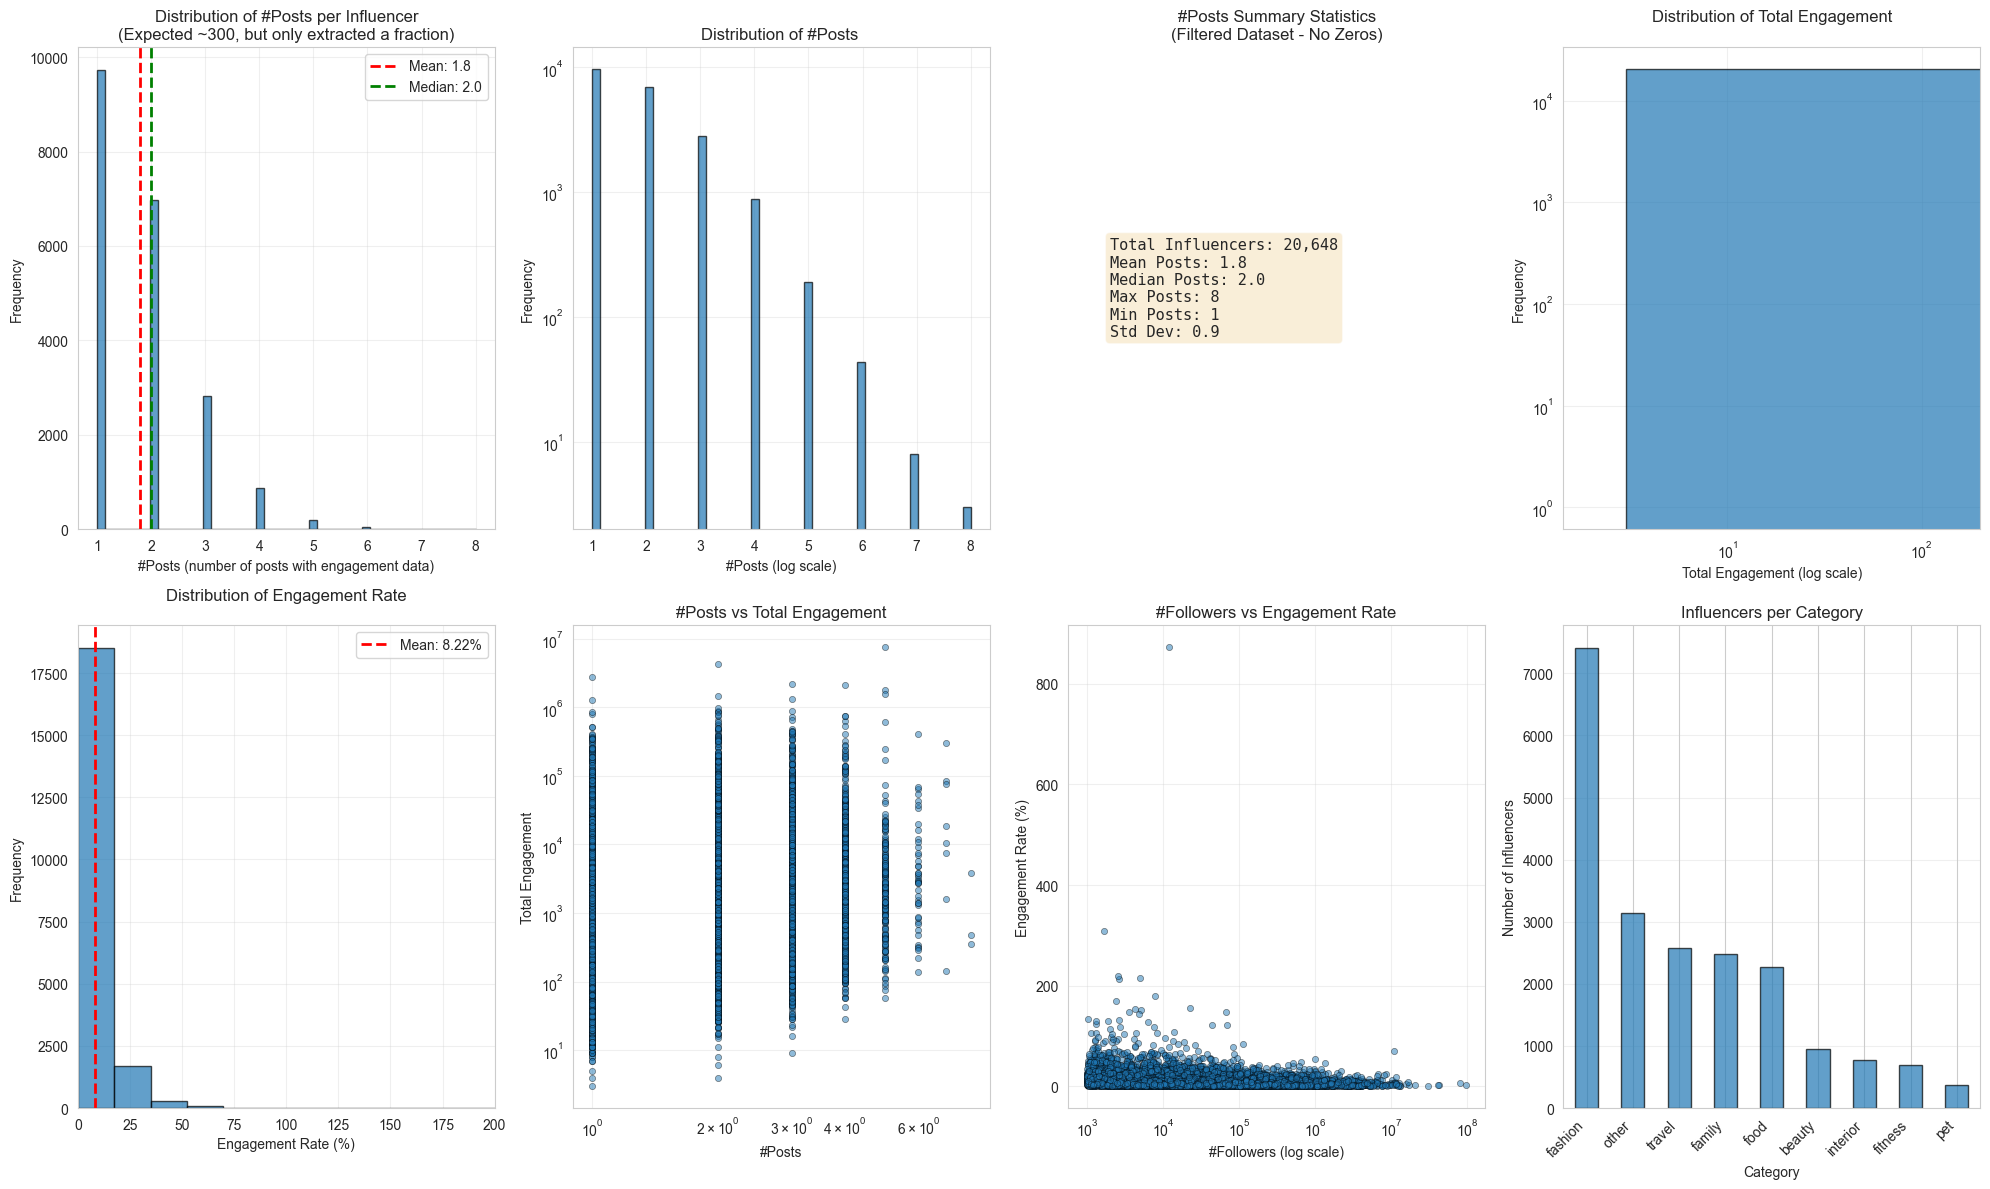


QUANTITATIVE VALIDATION SUMMARY
Dataset: cleaned_dataset_filtered.csv (NO ZEROS)

Data Quality Check:
  ✓ All engagement metrics > 0 (filtered)
  ✓ No zero values in dataset
  ✓ All influencers have engagement data

#Posts Statistics:
  Total influencers: 20,648
  Influencers with posts > 0: 20,648 (100.0%)
  Mean #Posts: 1.79
  Median #Posts: 2.00
  Max #Posts: 8
  Min #Posts: 1
  Expected: ~300 posts per influencer
  Actual: Only extracted a fraction of expected posts

Engagement Statistics:

Category Distribution:
  fashion: 7,400 (35.8%)
  other: 3,146 (15.2%)
  travel: 2,577 (12.5%)
  family: 2,483 (12.0%)
  food: 2,264 (11.0%)
  beauty: 957 (4.6%)
  interior: 770 (3.7%)
  fitness: 687 (3.3%)
  pet: 364 (1.8%)


In [73]:
## Data Validation Visualizations

# Using cleaned_dataset_filtered.csv (no zeros in any engagement metric)

# Use the filtered dataset (no zeros)
# Note: df_filtered is created in Cell 17, so make sure to run that cell first
if 'df_filtered' not in locals():
    print('⚠️ df_filtered not found. Loading from cleaned_dataset_filtered.csv...')
    df_filtered = pd.read_csv('datasets/cleaned_dataset_filtered.csv')
    print(f'✓ Loaded {len(df_filtered):,} influencers from cleaned_dataset_filtered.csv')


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

# Create figure with subplots
fig = plt.figure(figsize=(20, 12))

# 1. Distribution of #Posts per influencer
ax1 = plt.subplot(2, 4, 1)
df_filtered['#Posts'].hist(bins=50, edgecolor='black', alpha=0.7)
plt.axvline(df_filtered['#Posts'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df_filtered["#Posts"].mean():.1f}')
plt.axvline(df_filtered['#Posts'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {df_filtered["#Posts"].median():.1f}')
plt.xlabel('#Posts (number of posts with engagement data)')
plt.ylabel('Frequency')
plt.title('Distribution of #Posts per Influencer\n(Expected ~300, but only extracted a fraction)')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Distribution of #Posts (log scale for better visibility)
ax2 = plt.subplot(2, 4, 2)
df_filtered['#Posts'].hist(bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('#Posts (log scale)')
plt.ylabel('Frequency')
plt.title('Distribution of #Posts ')
plt.yscale('log')
plt.grid(True, alpha=0.3)

# 3. Summary statistics for #Posts
ax3 = plt.subplot(2, 4, 3)
posts_stats = {
    'Total Influencers': len(df_filtered),
    'Mean Posts': df_filtered['#Posts'].mean(),
    'Median Posts': df_filtered['#Posts'].median(),
    'Max Posts': df_filtered['#Posts'].max(),
    'Min Posts': df_filtered['#Posts'].min(),
    'Std Dev': df_filtered['#Posts'].std(),
}
stats_text = '\n'.join([f'{k}: {v:.1f}' if isinstance(v, float) else f'{k}: {v:,}' 
                        for k, v in posts_stats.items()])
ax3.text(0.1, 0.5, stats_text, fontsize=11, verticalalignment='center', 
         family='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax3.axis('off')
ax3.set_title('#Posts Summary Statistics\n(Filtered Dataset - No Zeros)')

# 4. Distribution of Total Engagement
ax4 = plt.subplot(2, 4, 4)
df_filtered['Total_Engagement'].hist(bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Total Engagement (log scale)')
plt.ylabel('Frequency')
plt.title('Distribution of Total Engagement\n')
plt.yscale('log')
plt.xscale('log')
plt.grid(True, alpha=0.3)

# 5. Distribution of Engagement Rate
plt.xlim(0, 200)  # Limit x-axis to 200% (no values above this)
ax5 = plt.subplot(2, 4, 5)
df_filtered['Engagement_Rate'].hist(bins=50, edgecolor='black', alpha=0.7)
plt.axvline(df_filtered['Engagement_Rate'].mean(), 
            color='red', linestyle='--', linewidth=2, 
            label=f'Mean: {df_filtered["Engagement_Rate"].mean():.2f}%')
plt.xlabel('Engagement Rate (%)')
plt.ylabel('Frequency')
plt.title('Distribution of Engagement Rate\n')
plt.xlim(0, 200)  # Limit x-axis to 200% (no values above this)
plt.legend()
plt.grid(True, alpha=0.3)

# 6. #Posts vs Total Engagement (scatter)
ax6 = plt.subplot(2, 4, 6)
df_with_data = df_filtered
plt.scatter(df_with_data['#Posts'], df_with_data['Total_Engagement'], 
           alpha=0.5, s=20, edgecolors='black', linewidth=0.5)
plt.xlabel('#Posts')
plt.ylabel('Total Engagement')
plt.title('#Posts vs Total Engagement')
plt.xscale('log')
plt.yscale('log')
plt.grid(True, alpha=0.3)

# 7. #Followers vs Engagement Rate (scatter)
ax7 = plt.subplot(2, 4, 7)
df_with_engagement = df_filtered
plt.scatter(df_with_engagement['#Followers'], df_with_engagement['Engagement_Rate'], 
           alpha=0.5, s=20, edgecolors='black', linewidth=0.5)
plt.xlabel('#Followers (log scale)')
plt.ylabel('Engagement Rate (%)')
plt.title('#Followers vs Engagement Rate')
plt.xscale('log')
plt.grid(True, alpha=0.3)

# 8. Category distribution
ax8 = plt.subplot(2, 4, 8)
category_counts = df_filtered['Category'].value_counts()
category_counts.plot(kind='bar', edgecolor='black', alpha=0.7)
plt.xlabel('Category')
plt.ylabel('Number of Influencers')
plt.title('Influencers per Category')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')

ax9.set_ylabel('Count')
ax9.tick_params(axis='x', rotation=45)
plt.grid(True, alpha=0.3, axis='y')
# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax9.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}',
            ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('data_validation_plots.png', dpi=150, bbox_inches='tight')
print("✓ Saved validation plots to: data_validation_plots.png")
plt.show()

# Print summary statistics
print("\n" + "="*70)
print("QUANTITATIVE VALIDATION SUMMARY")
print("Dataset: cleaned_dataset_filtered.csv (NO ZEROS)")

print(f"\nData Quality Check:")
print(f"  ✓ All engagement metrics > 0 (filtered)")
print(f"  ✓ No zero values in dataset")
print(f"  ✓ All influencers have engagement data")
print("="*70)
print(f"\n#Posts Statistics:")
print(f"  Total influencers: {len(df_filtered):,}")
print(f"  Influencers with posts > 0: {(df_filtered['#Posts'] > 0).sum():,} ({(df_filtered['#Posts'] > 0).sum()/len(df_filtered)*100:.1f}%)")
print(f"  Mean #Posts: {df_filtered['#Posts'].mean():.2f}")
print(f"  Median #Posts: {df_filtered['#Posts'].median():.2f}")
print(f"  Max #Posts: {df_filtered['#Posts'].max():.0f}")
print(f"  Min #Posts: {df_filtered['#Posts'].min():.0f}")
print(f"  Expected: ~300 posts per influencer")
print(f"  Actual: Only extracted a fraction of expected posts")

print(f"\nEngagement Statistics:")
print(f"\nCategory Distribution:")
for category, count in df_filtered['Category'].value_counts().head(10).items():
    print(f"  {category}: {count:,} ({count/len(df_filtered)*100:.1f}%)")

print("="*70)
